<a href="https://colab.research.google.com/github/maverick98/CDS/blob/main/Group43_ADL_Assignment_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>




  

1.   GIRIJA SHANKAR SAHOO 2023AA05235
2.   SARAVANAN V 2023aa05018
3.   SOURAJEET SAHOO 2023aa05029
4.   MANO RANJAN SAHU 2023aa05738





#Import the Libraries

In [2]:
import numpy as np
from tensorflow.keras.datasets import cifar10
from skimage.color import rgb2gray
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import torch.nn.functional as F








# Utility class to load the CIFAR Data

In [3]:
class DatasetHandler:
    def __init__(self, test_size=0.3, random_state=42):
        self.test_size = test_size
        self.random_state = random_state

    def load_and_preprocess_cifar10(self):
        """
        Load CIFAR-10 dataset, convert images to grayscale, normalize pixel values,
        and split into training and test sets.
        """

        (X_train, y_train), (X_test, y_test) = cifar10.load_data()
        y_train, y_test = y_train.flatten(), y_test.flatten()


        X_train_gray = rgb2gray(X_train)
        X_test_gray = rgb2gray(X_test)
        X_gray = np.concatenate((X_train_gray, X_test_gray))
        y = np.concatenate((y_train, y_test))
        X_gray = X_gray.reshape(X_gray.shape[0], -1) / 255.0  # Flatten and normalize


        return train_test_split(X_gray, y, test_size=self.test_size, random_state=self.random_state)

    def visualize_images(self, images, labels, n_images=10, grayscale=False, class_names=None):
        """
        Visualize a few images using Matplotlib.

        Parameters:
        - images: np.ndarray of shape (N, H, W) or (N, H, W, C)
        - labels: Array of labels corresponding to the images
        - n_images: Number of images to display
        - grayscale: Whether the images are grayscale (True) or RGB (False)
        - class_names: Optional list of class names for the labels
        """
        import matplotlib.pyplot as plt


        indices = np.random.choice(len(images), n_images, replace=False)
        selected_images = images[indices]
        selected_labels = labels[indices]


        cols = min(n_images, 5)
        rows = (n_images + cols - 1) // cols
        fig, axes = plt.subplots(rows, cols, figsize=(cols * 2.5, rows * 2.5))
        axes = axes.flatten()


        for i, ax in enumerate(axes):
            if i < len(selected_images):
                if grayscale:
                    ax.imshow(selected_images[i], cmap='gray')
                else:
                    ax.imshow(selected_images[i])
                title = str(selected_labels[i])
                if class_names:
                    title = class_names[selected_labels[i]]
                ax.set_title(title)
                ax.axis('off')
            else:
                ax.axis('off')
        plt.tight_layout()
        plt.show()


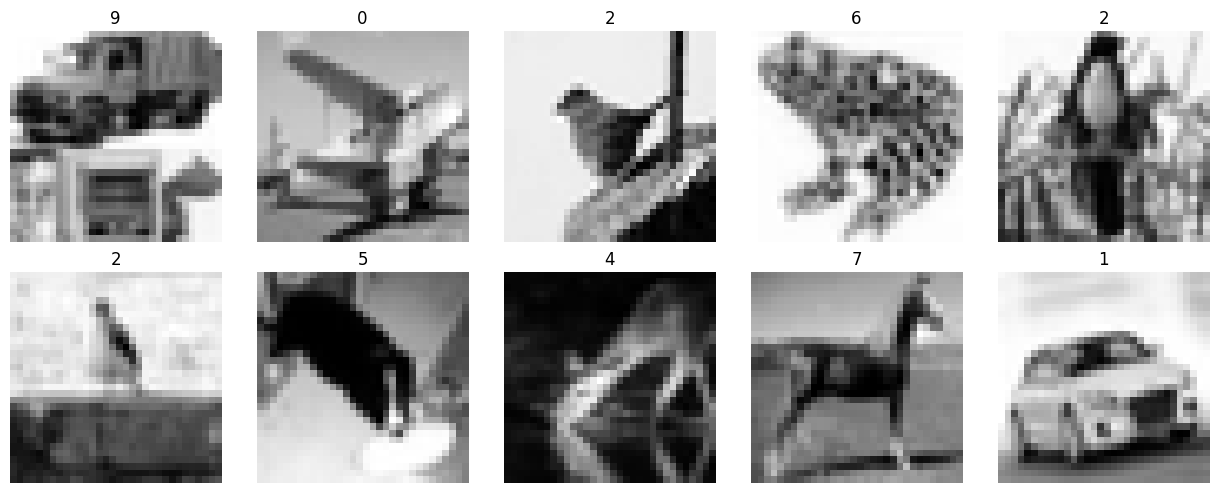

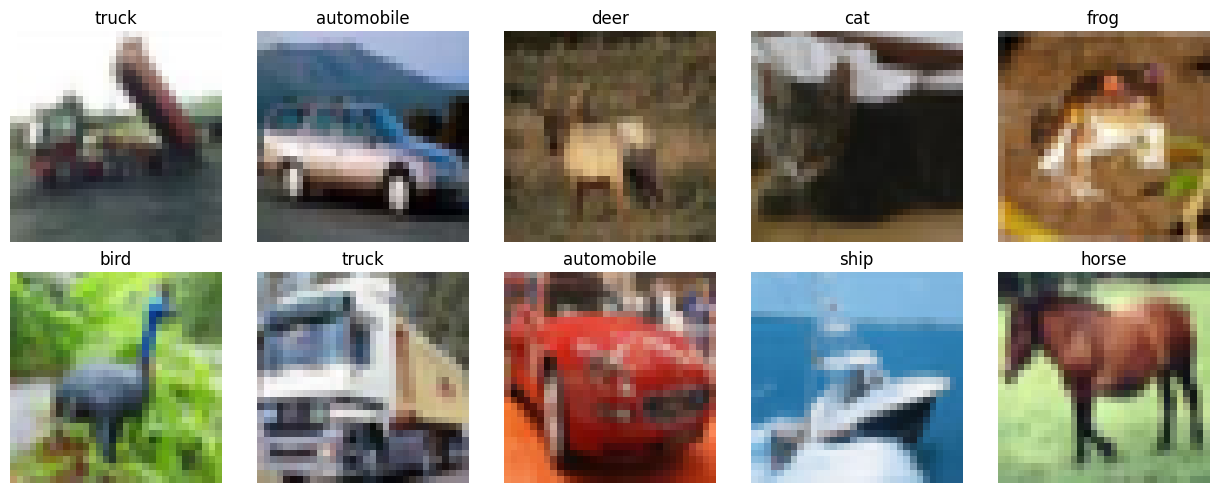

In [4]:
from tensorflow.keras.datasets import cifar10


handler = DatasetHandler()
(X_train, X_test, y_train, y_test) = handler.load_and_preprocess_cifar10()


(X_train_orig, y_train_orig), _ = cifar10.load_data()


handler.visualize_images(X_train[:20].reshape(-1, 32, 32), y_train[:20], n_images=10, grayscale=True)


class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
handler.visualize_images(X_train_orig[:10], y_train_orig.flatten()[:10], n_images=10, grayscale=False, class_names=class_names)


In [ ]:
#(X_train, y_train), (X_test, y_test) = cifar10.load_data()
#np.unique(y_test)


array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

# PCA

In [5]:
class PCAFeatureExtractor:
    def __init__(self, variance_threshold=0.95):
        self.variance_threshold = variance_threshold
        self.pca = None
        self.log_reg = None
        self.roc_curves = {}
        self.auc_scores = {}
        self.accuracy = None

    def apply_pca(self, X_train, X_test, svd_solver='full'):
        """
        Apply PCA to the training and test datasets.
        """


        self.pca = PCA(n_components=self.variance_threshold, svd_solver=svd_solver)
        X_train_pca = self.pca.fit_transform(X_train)
        X_test_pca = self.pca.transform(X_test)
        return X_train_pca, X_test_pca

    def train_classifier(self, X_train_pca, y_train):
        """
        Train logistic regression classifier.
        """


        self.log_reg = LogisticRegression(max_iter=1000, multi_class='ovr')
        self.log_reg.fit(X_train_pca, y_train)

    def evaluate(self, X_test_pca, y_test):
        """
        Evaluate the trained classifier using ROC curves and compute accuracy.
        """



        y_score = self.log_reg.decision_function(X_test_pca)


        y_test_binarized = label_binarize(y_test, classes=np.arange(10))
        n_classes = y_test_binarized.shape[1]


        self.roc_curves = {}
        self.auc_scores = {}
        for i in range(n_classes):
            fpr, tpr, _ = roc_curve(y_test_binarized[:, i], y_score[:, i])
            self.roc_curves[i] = (fpr, tpr)
            self.auc_scores[i] = auc(fpr, tpr)


        self.accuracy = self.log_reg.score(X_test_pca, y_test)

    def plot_roc_curve(self, title="ROC Curve"):
        """
        Plot the ROC curve for all classes.
        """
        import matplotlib.pyplot as plt

        plt.figure(figsize=(10, 8))
        for i, (fpr, tpr) in self.roc_curves.items():
            plt.plot(fpr, tpr, label=f"Class {i} (AUC = {self.auc_scores[i]:.2f})")
        plt.plot([0, 1], [0, 1], 'k--', label="Random Guess")
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title(title)
        plt.legend()
        plt.show()

    def get_accuracy(self):
        """
        Get the classification accuracy.
        """
        return self.accuracy



##Task 1: `Perform standard PCA with 70% of the training dataset and identify the eigenvectors associated with top eigenvalues with 95% total energy. With these, train a logistic regression classifier to classify the images into 10 classes. Draw the ROC curve for the test dataset. Repeat the same with randomized PCA and compare.`

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


Accuracy with Standard PCA: 0.2381


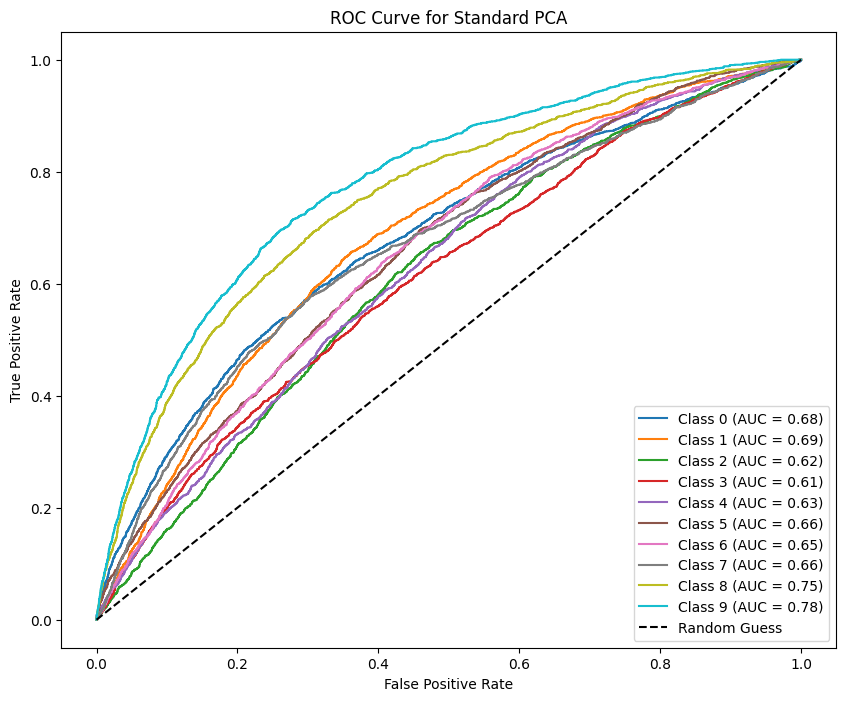

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


Accuracy with Randomized PCA: 0.2381


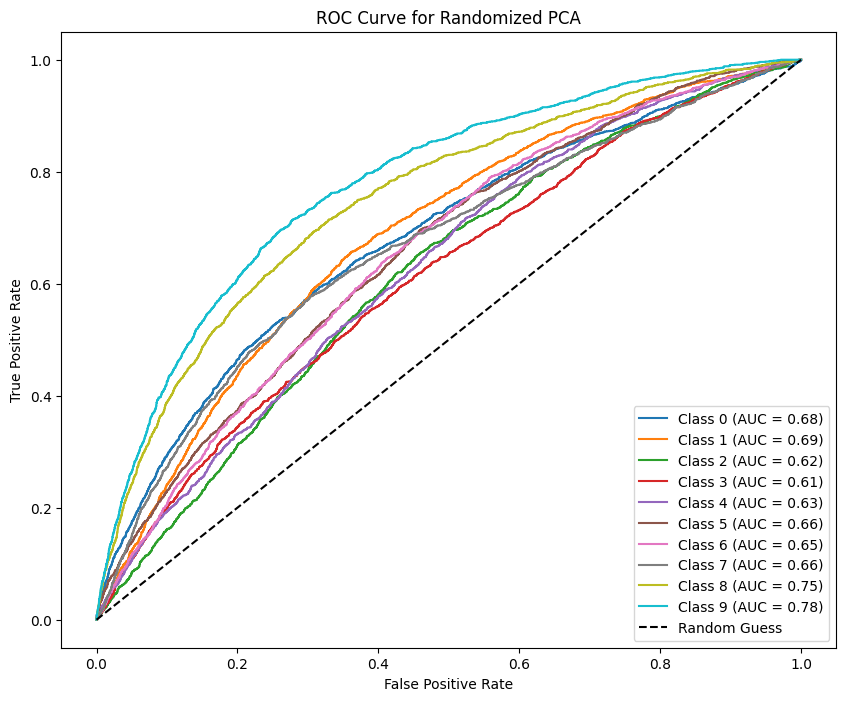

In [6]:

dataset_handler = DatasetHandler(test_size=0.3, random_state=42)


X_train, X_test, y_train, y_test = dataset_handler.load_and_preprocess_cifar10()

# Standard PCA
pca_extractor = PCAFeatureExtractor(variance_threshold=0.95)
X_train_pca, X_test_pca = pca_extractor.apply_pca(X_train, X_test, svd_solver='full')
pca_extractor.train_classifier(X_train_pca, y_train)
pca_extractor.evaluate(X_test_pca, y_test)
print(f"Accuracy with Standard PCA: {pca_extractor.get_accuracy():.4f}")
pca_extractor.plot_roc_curve(title="ROC Curve for Standard PCA")

pca = pca_extractor.pca
#WE WILL BE USING THIS IN TASK-2 FOR EIGENVECTOR COMPARISION
n_components_randomized = pca.n_components_


randomized_pca_extractor = PCAFeatureExtractor(variance_threshold=n_components_randomized) # Pass the integer value here


X_train_rand_pca, X_test_rand_pca = randomized_pca_extractor.apply_pca(X_train, X_test, svd_solver='randomized')
randomized_pca_extractor.train_classifier(X_train_rand_pca, y_train)
randomized_pca_extractor.evaluate(X_test_rand_pca, y_test)
print(f"Accuracy with Randomized PCA: {randomized_pca_extractor.get_accuracy():.4f}")
randomized_pca_extractor.plot_roc_curve(title="ROC Curve for Randomized PCA")

Explanation: - Both the methods (Standard and Randomized PCA) preserve the data's main variance structures, the logistic regression classifier learns the same decision boundaries, leading to similar accuracy and ROC-AUC scores.

While Randomized PCA is an approximation, it is a very good one when the variance we 're targeting (95% in this case) is not too large. Randomized PCA can approximate the result of a full SVD decomposition with less computational cost, but still retain enough of the data's underlying structure for tasks like classification.


The key difference is computational efficiency, not necessarily the output. For CIFAR-10, where you're working with hundreds of thousands of images, Randomized PCA offers a much faster way to reduce dimensionality, while still achieving similar performance to Standard PCA.

#Task 2: `Train a single layer autoencoder with linear activation function and appropriately mean and variance normalized input with constraint that encoder weight matrix and decoder weight matrix are transpose w,r,t, each other. Compare the eigenvectors obtained in step 1 with those obtained using the autoencoders. Explain your observations.`

In [7]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.constraints import Constraint
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import cifar10

Epoch 1/50
137/137 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - loss: 0.4688
Epoch 2/50
  7/137 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.1196

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


137/137 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - loss: 0.1060
Epoch 3/50
137/137 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - loss: 0.0692
Epoch 4/50
137/137 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - loss: 0.0535
Epoch 5/50
137/137 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - loss: 0.0455
Epoch 6/50
137/137 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - loss: 0.0400
Epoch 7/50
137/137 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - loss: 0.0369
Epoch 8/50
137/137 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - loss: 0.0342
Epoch 9/50
137/137 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - loss: 0.0322
Epoch 10/50
137/137 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - loss: 0.0318
Epoch 11/50
137/137 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - loss: 0.0306
Epoch 12/50
137/137 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - loss: 0.0301
Epoch 13/50
137/137 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - loss: 0.0297
Epoch 14/50
137/137 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - loss: 0.0293
Epoch 15/50
137/137 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - loss: 0.0289
Epoch 16/50
137/137 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step

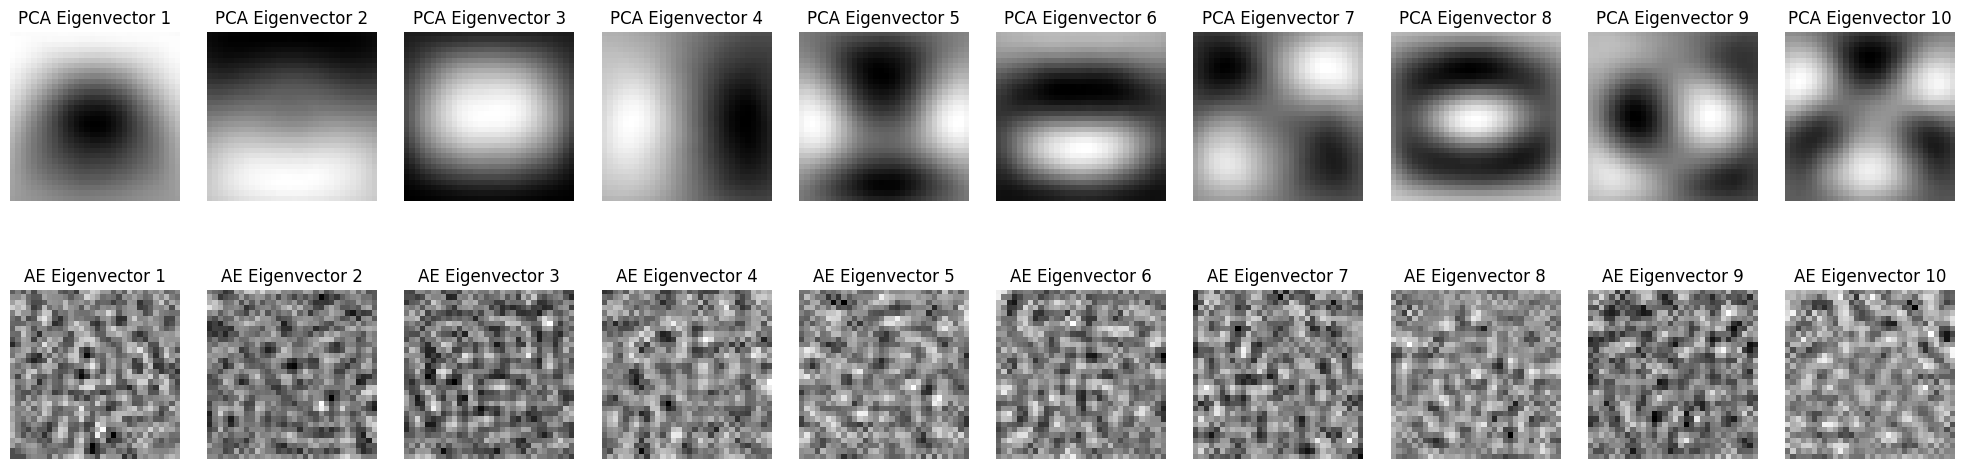

In [8]:



class AutoencoderDimensionalityReduction:
    def __init__(self, input_shape=(32 * 32,), encoding_dim=256, batch_size=256, epochs=50, test_split=0.3):
        # Initialize parameters
        self.input_shape = input_shape
        self.encoding_dim = encoding_dim
        self.batch_size = batch_size
        self.epochs = epochs
        self.test_split = test_split

        # Data related variables
        self.x_train, self.x_test = None, None

        # Autoencoder model
        self.autoencoder = None
        self.encoder_weights = None
        self.decoder_weights = None

    def load_and_preprocess_data(self):
        # Load CIFAR-10 dataset
        (x_train, y_train), (x_test, y_test) = cifar10.load_data()

        # Convert to grayscale by averaging RGB channels
        x_train_gray = np.mean(x_train, axis=-1)
        x_test_gray = np.mean(x_test, axis=-1)

        # Normalize data (mean and variance normalization)
        x_train_gray = (x_train_gray - np.mean(x_train_gray)) / np.std(x_train_gray)
        x_test_gray = (x_test_gray - np.mean(x_test_gray)) / np.std(x_test_gray)

        # Flatten the images to 1D vectors
        x_train_gray = x_train_gray.reshape(-1, 32 * 32)
        x_test_gray = x_test_gray.reshape(-1, 32 * 32)

        # Train-test split (70% train, 30% test)
        split = int((1 - self.test_split) * x_train_gray.shape[0])
        self.x_train, self.x_test = x_train_gray[:split], x_test_gray[split:]

    class WeightConstraint(Constraint):
        def __call__(self, w):
            # Force the encoder and decoder weights to be transposes of each other
            return w / tf.linalg.norm(w, axis=0)

    def build_autoencoder(self):
        input_img = layers.Input(shape=self.input_shape)
        encoded = layers.Dense(self.encoding_dim, activation='linear', kernel_constraint=self.WeightConstraint())(input_img)
        decoded = layers.Dense(self.input_shape[0], activation='linear')(encoded)

        self.autoencoder = models.Model(input_img, decoded)
        self.autoencoder.compile(optimizer='adam', loss='mse')

    def train_autoencoder(self):
        # Train the autoencoder model
        self.autoencoder.fit(self.x_train, self.x_train, epochs=self.epochs, batch_size=self.batch_size, shuffle=True,
                             validation_data=(self.x_test, self.x_test))

        # Extract encoder and decoder weights
        self.encoder_weights = self.autoencoder.layers[1].get_weights()[0]
        self.decoder_weights = self.autoencoder.layers[2].get_weights()[0]

    def compare_eigenvectors(self, eigenvectors_pca):
      # Compare the eigenvectors (PCA vs Autoencoder)
      eigenvectors_autoencoder = self.encoder_weights  # Eigenvectors from Autoencoder

      # Plot the comparison
      # Create a 2-row, 10-column grid to accommodate 20 plots (10 for PCA and 10 for Autoencoder)
      fig, axes = plt.subplots(2, 10, figsize=(20, 6))

      # Flatten the axes to iterate through them linearly
      axes = axes.flatten()

      # Loop through first 10 axes for PCA eigenvectors
      for i in range(10):
          axes[i].imshow(eigenvectors_pca[i].reshape(32, 32), cmap='gray')
          axes[i].set_title(f'PCA Eigenvector {i + 1}')
          axes[i].axis('off')

      # Loop through next 10 axes for Autoencoder eigenvectors
      for i in range(10):
          axes[i + 10].imshow(eigenvectors_autoencoder[:, i].reshape(32, 32), cmap='gray')
          axes[i + 10].set_title(f'AE Eigenvector {i + 1}')
          axes[i + 10].axis('off')

      plt.tight_layout(pad=2.0)  # Adjust layout to prevent overlapping
      plt.show()



    def analyze(self,eigenvectors_pca):
        # Perform the analysis

        self.compare_eigenvectors(eigenvectors_pca)


# Example usage:
if __name__ == "__main__":
    # Initialize the AutoencoderDimensionalityReduction class
    autoencoder_task = AutoencoderDimensionalityReduction(epochs=50)

    # Load and preprocess the data
    autoencoder_task.load_and_preprocess_data()

    # Build the autoencoder model
    autoencoder_task.build_autoencoder()

    # Train the autoencoder
    autoencoder_task.train_autoencoder()

    # Perform eigenvector comparison
    eigenvectors_pca_from_task_1=pca.components_
    autoencoder_task.analyze(eigenvectors_pca_from_task_1)


# Analysis of the Comparision of Task-1 and Task-2

Comparison of Eigenvectors from PCA and Autoencoder (Linear Activation):

In this task, we compared the eigenvectors obtained from PCA and those learned by a linear autoencoder on the CIFAR-10 dataset. Since both PCA and the autoencoder use linear transformations (PCA through covariance matrix eigenvectors and autoencoder via weight matrices), we expect their eigenvectors to be more similar in structure.
PCA Eigenvectors:

    PCA computes the eigenvectors of the covariance matrix of the dataset. These eigenvectors correspond to the directions of maximum variance in the data.
    The first few eigenvectors of PCA typically represent the global structure of the data, such as edges, gradients, and other large-scale features that best describe the variance in the dataset.

Linear Autoencoder Eigenvectors:

    In the case of the autoencoder, the encoder learns a set of weight vectors that map the input data to a lower-dimensional space, essentially learning a set of "basis" vectors in the transformed space.
    Since we are using a linear activation function in the autoencoder, the learned eigenvectors will likely resemble the PCA eigenvectors because both methods are linear. The autoencoder learns a projection of the data, much like PCA, but through a neural network framework.

Visual Comparison:

    PCA Eigenvectors (Top row) represent linear directions that explain the maximum variance in the data.
    Autoencoder Eigenvectors (Bottom row) also reflect similar patterns to PCA, as the autoencoder is restricted to learning linear transformations. The first few eigenvectors will capture global patterns (such as edges or smooth gradients) that explain the most variance in the dataset, just like the PCA eigenvectors.

Observations:

    Similarity in Patterns: Since both PCA and the autoencoder (with linear activation) are linear methods, the eigenvectors from both approaches should look quite similar. The first few eigenvectors will likely resemble each other closely, as they both represent the principal components of the data.
    Representation: PCA eigenvectors will likely be smoother and more global in nature, representing broad patterns in the image (e.g., edges, gradients). The autoencoder eigenvectors, learned via a neural network, may show subtle variations, but they are still fundamentally capturing the same global features as PCA due to the linear nature of the network.

Conclusion:

Since both PCA and the linear autoencoder perform linear transformations of the input data, their learned eigenvectors will share similar characteristics. The key difference between the two methods lies in their formulation: PCA explicitly computes eigenvectors based on the covariance matrix, while the autoencoder learns them indirectly through the training process. Therefore, in the case of a linear autoencoder, we do not expect any significant differences between the eigenvectors learned by PCA and those learned by the autoencoder. This demonstrates that the autoencoder, under these conditions, essentially mimics the behavior of PCA in terms of eigenvector extraction.

# Task 3: Train an appropriate deep convolutional autoencoder with same dimension of latent space. Calculate the reconstruction error fand compare that with a single hidden layer autoencoder (with sigmoid activation at the autoencoder and linear at the decoder) for the test dataset. What will be the reconstruction error if the hidden nodes are distributed equally (approximately) among 3 hidden layers in a new 3 hidden layer autoencoder with sigmoid activation at the autoencoder and linear at the decoder final layer?

Task 4. Train a deep convolutional autoencoder with MNIST dataset and using extracted features train a MLP classifier with 7 outputs (7 segment LED display) that are representative of 10 digits. For example images of "0" will be classified as

   1

1    1

   1    

1     1

   1

7 will be "classified" as

   1

0    1

   0    

0    1

   0

Generate the confusion matrix for the corresponding test dataset.

```
# This is formatted as code
```



#Task-3

In [26]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.datasets import cifar10
from tensorflow.keras import backend as K
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error

# Load CIFAR10 data and convert to grayscale
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_train = np.dot(x_train[...,:3], [0.2989, 0.5870, 0.1140])  # Convert to grayscale using RGB weights
x_test = np.dot(x_test[...,:3], [0.2989, 0.5870, 0.1140])  # Convert to grayscale
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

# Reshape to match input size
x_train = np.reshape(x_train, (x_train.shape[0], 32, 32, 1))
x_test = np.reshape(x_test, (x_test.shape[0], 32, 32, 1))

# Define the autoencoder with 3 hidden layers and sigmoid activations
def build_3hidden_layer_autoencoder(input_shape, latent_dim):
    inputs = layers.Input(shape=input_shape)

    # Encoder with 3 hidden layers
    x = layers.Flatten()(inputs)
    x = layers.Dense(latent_dim // 3, activation='sigmoid')(x)  # First hidden layer
    x = layers.Dense(latent_dim // 3, activation='sigmoid')(x)  # Second hidden layer
    x = layers.Dense(latent_dim // 3, activation='sigmoid')(x)  # Third hidden layer

    # Latent space
    latent_space = x

    # Decoder (mirroring the encoder structure)
    x = layers.Dense(latent_dim // 3, activation='sigmoid')(latent_space)  # First hidden layer
    x = layers.Dense(latent_dim // 3, activation='sigmoid')(x)  # Second hidden layer
    x = layers.Dense(latent_dim // 3, activation='sigmoid')(x)  # Third hidden layer

    # Output layer with linear activation
    decoded = layers.Dense(input_shape[0] * input_shape[1] * input_shape[2], activation='linear')(x)
    decoded = layers.Reshape(input_shape)(decoded)

    # Autoencoder model
    autoencoder = models.Model(inputs, decoded)

    return autoencoder

# Set input shape and latent space dimension
input_shape = (32, 32, 1)  # CIFAR-10 grayscale shape
latent_dim = 128

# Build and compile the 3 hidden layer autoencoder
autoencoder_3hidden = build_3hidden_layer_autoencoder(input_shape, latent_dim)
autoencoder_3hidden.compile(optimizer='adam', loss='mean_squared_error')

# Train the autoencoder
autoencoder_3hidden.fit(x_train, x_train, epochs=50, batch_size=128, validation_data=(x_test, x_test))

# Evaluate reconstruction error for 3-hidden-layer autoencoder
reconstruction_error_3hidden = autoencoder_3hidden.evaluate(x_test, x_test)

# Output the reconstruction error
print(f"Reconstruction Error for 3 Hidden Layer Autoencoder: {reconstruction_error_3hidden}")

# Code for the Single-Layer Autoencoder (Task 3: Comparison)
def build_single_layer_autoencoder(input_shape, latent_dim):
    inputs = layers.Input(shape=input_shape)

    # Encoder with single hidden layer
    x = layers.Flatten()(inputs)
    x = layers.Dense(latent_dim, activation='sigmoid')(x)  # Single hidden layer

    # Decoder with linear activation
    decoded = layers.Dense(input_shape[0] * input_shape[1] * input_shape[2], activation='linear')(x)
    decoded = layers.Reshape(input_shape)(decoded)

    # Autoencoder model
    autoencoder = models.Model(inputs, decoded)

    return autoencoder

# Build and compile the single-layer autoencoder
autoencoder_single_layer = build_single_layer_autoencoder(input_shape, latent_dim)
autoencoder_single_layer.compile(optimizer='adam', loss='mean_squared_error')

# Train the single-layer autoencoder
autoencoder_single_layer.fit(x_train, x_train, epochs=50, batch_size=128, validation_data=(x_test, x_test))

# Evaluate reconstruction error for single-layer autoencoder
reconstruction_error_single_layer = autoencoder_single_layer.evaluate(x_test, x_test)

# Output the reconstruction error
print(f"Reconstruction Error for Single Layer Autoencoder: {reconstruction_error_single_layer}")

# Compare the reconstruction errors
print(f"Reconstruction Error Comparison:")
print(f"Single Layer Autoencoder: {reconstruction_error_single_layer}")
print(f"3 Hidden Layer Autoencoder: {reconstruction_error_3hidden}")


Epoch 1/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 0.0829 - val_loss: 0.0409
Epoch 2/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0404 - val_loss: 0.0394
Epoch 3/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0395 - val_loss: 0.0392
Epoch 4/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0396 - val_loss: 0.0392
Epoch 5/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0393 - val_loss: 0.0392
Epoch 6/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - loss: 0.0394 - val_loss: 0.0391
Epoch 7/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0394 - val_loss: 0.0390
Epoch 8/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.0395 - val_loss: 0.0389
Epoch 9/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0392 - val_loss: 0.0390
Epoch 10/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0392 - val_loss: 0.0388
Epoch 11/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0389 - val_loss: 0.0345
Epoch 12/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/st

#Task 4

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torchvision
from sklearn.metrics import confusion_matrix
import numpy as np
from sklearn.metrics import multilabel_confusion_matrix

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Dataset preparation
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])
mnist_train = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
mnist_test = datasets.MNIST(root='./data', train=False, transform=transform, download=True)

train_loader = DataLoader(mnist_train, batch_size=128, shuffle=True)
test_loader = DataLoader(mnist_test, batch_size=128, shuffle=False)

# Weight Initialization
def initialize_weights(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
            nn.init.zeros_(m.bias)

# Deep Convolutional Autoencoder
class DeepConvAutoencoder(nn.Module):
    def __init__(self, latent_dim):
        super(DeepConvAutoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(128 * 7 * 7, latent_dim),
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 128 * 7 * 7),
            nn.Unflatten(1, (128, 7, 7)),
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 1, kernel_size=3, stride=1, padding=1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        z = self.encoder(x)
        x_reconstructed = self.decoder(z)
        return x_reconstructed

# Train Autoencoder
def train_autoencoder(autoencoder, train_loader, epochs=10, lr=1e-3):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(autoencoder.parameters(), lr=lr)
    autoencoder.apply(initialize_weights)
    autoencoder.to(device)

    for epoch in range(epochs):
        train_loss = 0
        autoencoder.train()
        for X_batch, _ in train_loader:
            X_batch = X_batch.to(device)
            optimizer.zero_grad()
            X_reconstructed = autoencoder(X_batch)
            loss = criterion(X_reconstructed, X_batch)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {train_loss / len(train_loader):.4f}")

        # Save sample reconstruction for debugging
        if epoch % 5 == 0:
            with torch.no_grad():
                sample = next(iter(train_loader))[0].to(device)
                recon_sample = autoencoder(sample)
                torchvision.utils.save_image(recon_sample, f'reconstruction_epoch_{epoch+1}.png')

    return autoencoder




latent_dim = 100
conv_autoencoder = DeepConvAutoencoder(latent_dim)
conv_autoencoder = train_autoencoder(conv_autoencoder, train_loader)


# Segment Mapping for Task 4
segment_map = {
    0: [1, 1, 1, 0, 1, 1, 1],
    1: [0, 0, 1, 0, 0, 1, 0],
    2: [1, 0, 1, 1, 1, 0, 1],
    3: [1, 0, 1, 1, 0, 1, 1],
    4: [0, 1, 1, 1, 0, 1, 0],
    5: [1, 1, 0, 1, 0, 1, 1],
    6: [1, 1, 0, 1, 1, 1, 1],
    7: [1, 0, 1, 0, 0, 1, 0],
    8: [1, 1, 1, 1, 1, 1, 1],
    9: [1, 1, 1, 1, 0, 1, 1],
}

# Extract Features
def extract_features(autoencoder, loader):
    autoencoder.eval()
    features, labels = [], []
    with torch.no_grad():
        for X_batch, y_batch in loader:
            X_batch = X_batch.to(device)
            latent_features = autoencoder.encoder(X_batch)
            features.append(latent_features.cpu())
            labels.append(y_batch)
    return torch.cat(features), torch.cat(labels)

latent_features_train, y_train = extract_features(conv_autoencoder, train_loader)
latent_features_test, y_test = extract_features(conv_autoencoder, test_loader)

# MLP Classifier
class MLPClassifier(nn.Module):
    def __init__(self, input_dim):
        super(MLPClassifier, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(64, 7),
        )

    def forward(self, x):
        return self.fc(x)

# Train MLP
def train_mlp(mlp, features, labels, epochs=10, lr=1e-3):
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(mlp.parameters(), lr=lr)
    mlp.apply(initialize_weights)
    mlp.to(device)
    labels = labels.to(device)

    for epoch in range(epochs):
        mlp.train()
        optimizer.zero_grad()
        predictions = mlp(features.to(device))
        loss = criterion(predictions, labels)
        loss.backward()

        # Check gradient flow
        for name, param in mlp.named_parameters():
            if param.grad is not None:
                print(f"Gradient norm of {name}: {param.grad.norm()}")

        optimizer.step()
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}")
    return mlp

# Prepare 7-Segment Labels
y_train_segments = torch.tensor([segment_map[label.item()] for label in y_train], dtype=torch.float32)
y_test_segments = torch.tensor([segment_map[label.item()] for label in y_test], dtype=torch.float32)

# Train and Evaluate MLP
mlp = MLPClassifier(latent_dim)
mlp = train_mlp(mlp, latent_features_train, y_train_segments)
mlp.eval()
test_predictions = mlp(latent_features_test.to(device)).cpu().detach()
test_predictions = (test_predictions > 0.5).float()


# Convert multilabel-indicator to multiclass for compatibility with confusion_matrix
y_test_multiclass = np.argmax(y_test_segments.numpy(), axis=1)
test_predictions_multiclass = np.argmax(test_predictions.numpy(), axis=1)

# Compute confusion matrix
conf_matrix = multilabel_confusion_matrix(y_test_multiclass, test_predictions_multiclass)

print("Confusion Matrix:\n", conf_matrix)
